In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


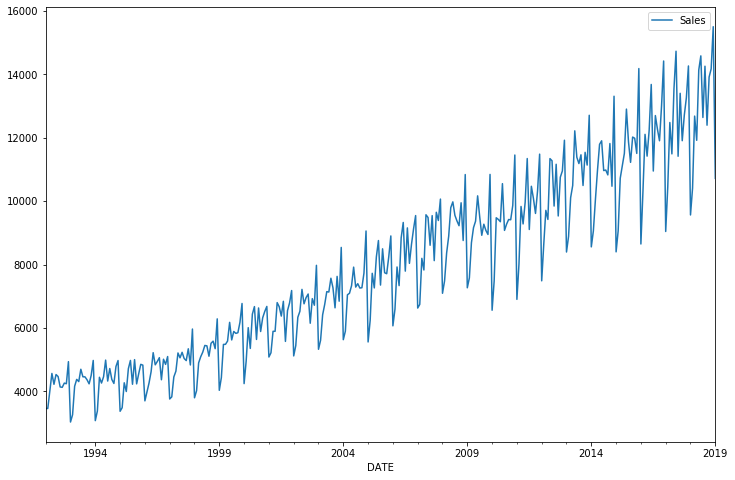

In [3]:
df.columns = ['Sales']
df.plot(figsize=(12,8))

In [4]:
train = df.iloc[:313]
test = df.iloc[313:]

In [5]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [6]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


In [7]:
X.flatten()

array([0.03658432, 0.03649885, 0.08299855, 0.13103684, 0.1017181 ,
       0.12804513, 0.12266006, 0.09453799, 0.09359774, 0.10496624,
       0.10334217, 0.16283443])

In [8]:
# creating model
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit model
model.fit_generator(generator,epochs=20)

Epoch 1/20
301/301 [==============================] - 3s 9ms/step - loss: 0.0181
Epoch 2/20
301/301 [==============================] - 2s 8ms/step - loss: 0.0089
Epoch 3/20
301/301 [==============================] - 2s 7ms/step - loss: 0.0089
Epoch 4/20
301/301 [==============================] - 2s 7ms/step - loss: 0.0092
Epoch 5/20
301/301 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 6/20
301/301 [==============================] - 2s 7ms/step - loss: 0.0071
Epoch 7/20
301/301 [==============================] - 2s 7ms/step - loss: 0.0069
Epoch 8/20
301/301 [==============================] - 2s 7ms/step - loss: 0.0053
Epoch 9/20
301/301 [==============================] - 2s 7ms/step - loss: 0.0043
Epoch 10/20
301/301 [==============================] - 2s 8ms/step - loss: 0.0036
Epoch 11/20
301/301 [==============================] - 2s 8ms/step - loss: 0.0033
Epoch 12/20
301/301 [==============================] - 2s 7ms/step - loss: 0.0025
Epoch 13/20
301/301 [====

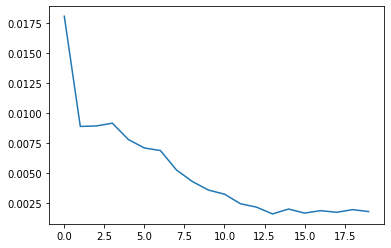

In [10]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [11]:
# evaluation
first_eval_batch = scaled_train[-12:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)
# scaled_test[0]

array([[0.708687]], dtype=float32)

In [12]:
# full predicitons
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [13]:
test_predictions

[array([0.708687], dtype=float32),
 array([0.84850854], dtype=float32),
 array([0.78571224], dtype=float32),
 array([0.94666624], dtype=float32),
 array([1.0277294], dtype=float32),
 array([0.7743755], dtype=float32),
 array([0.92610174], dtype=float32),
 array([0.8080718], dtype=float32),
 array([0.876691], dtype=float32),
 array([0.9206685], dtype=float32),
 array([0.98780376], dtype=float32),
 array([0.6292055], dtype=float32)]

In [14]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

In [15]:
# inverse scaler
true_predictions = scaler.inverse_transform(test_predictions)
test['prediction'] = true_predictions
test.head()

,Sales,prediction
DATE,,
2018-02-01,10415,11321.929300
2018-03-01,12683,12957.701372
2018-04-01,11919,12223.047521
2018-05-01,14138,14106.048350
2018-06-01,14583,15054.406158


In [16]:
import pandas as pd
from datetime import datetime

In [17]:
pd.date_range(start='1/1/2018', end='1/08/2030', freq='M')

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31',
               ...
               '2029-03-31', '2029-04-30', '2029-05-31', '2029-06-30',
               '2029-07-31', '2029-08-31', '2029-09-30', '2029-10-31',
               '2029-11-30', '2029-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')

In [18]:
pd.Timestamp(datetime.now()).month

8